In [30]:
# Andrew Dunn, Katherine Dumais, Kathryn Link-Oberstar, Lee-Or Bentovim
# Summary of initial feature engineering and model testing for checkpoint 2

# This analysis runs after we load, clean, and generate additional variables in load_data.py, 
# and initially explored the data in exploratory_analysis.ipynb.

In [31]:
# Import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import load_data
from evaluate_classification import evaluate_classification
SEED = 0

In [32]:
# Pull the different dataframes

# raw cleaned data
df, X_valid, y_valid = load_data.load_train_data()
X = df.iloc[:, :-1]
y = df.loc[:, 'Target']

# Create oversampled dataframes
train_X_resampled, train_y_resampled = load_data.gen_oversample_date()
X_smote, y_smote = load_data.gen_SMOTE_data()

**Feature Engineering**

We generate several new variables, derived from our literature review, in load_data.py:

- max_education_level: the education level of the person with the highest education level in the household
- hh_has_marriage: whether someone in the household is married
- hh_max_age: the age of the oldest person in the household
- hh_sex_ratio: the ratio of men to women in the household
- hh_child_woman_ratio_12: the ratio of children to women in the household, with children defined as being under 12
- hh_child_adult_ratio_12: the ratio of children to adults in the household, with children defined as being under 12
- hh_child_woman_ratio_19: the ratio of children to women in the household, with children defined as being under 19
- hh_child_adult_ratio_19: the ratio of children to adults in the household, with children defined as being under 19
- v2a1_log: the logged value of v2a1, the monthly rent payment. We also estimate and impute values into v2a1 when that field is missing.

**Model Testing**

We tested variations of four different models: random forest, naive bayes, KNN, and logistic regression in the following notebooks:

Below, we demonstrate the best performing variants of those models.

Accuracy: 0.66
F1 Score: 0.59
Recall: Label 1: 0.16 Label 2: 0.28 Label 3: 0.03 Label 4: 0.94


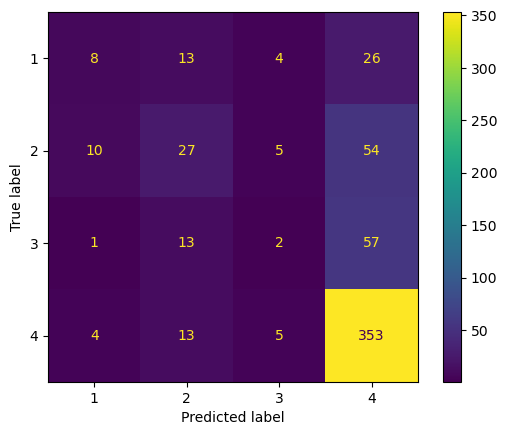

In [33]:
# Random Forest
clf = RandomForestClassifier(random_state = SEED,
                            n_estimators = 1600,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = 'sqrt',
                            max_depth = 100,
                            bootstrap = False
)
clf.fit(X, y)

y_pred = clf.predict(X_valid)
evaluate_classification(y_pred, y_valid, cm = True)

#### Naive Bayes

The Naive Bayes algorithm assumes that all features are independent of each other, meaning that the presence or absence of one feature does not affect the probability of another feature being present or absent. The algorithm uses Bayes' theorem to calculate the probabilities of different classes given the observed evidence. 

The Naive Bayes model is Scalable, can handle large datasets and high-dimensional feature spaces efficiently. However, one of the key assumptions of Naive Bayes is that features are conditionally independent given the class label. *This is almost certainly not true with this data.* 
Some other imitation of Naive Bayes include:
* *Data Scarcity*: Naive Bayes models can suffer when there is not enough data to estimate the probabilities accurately
* *Continuous features:* Naive Bayes models work better with categorical data. *We have a lot of bianry and continuous data*
* *Imbalanced Datasets*: Naive Bayes models may not perform well on an imbalanced dataset, where the classes are not represented equally. This can lead to poor classification performance, as the Naive Bayes algorithm may be biased towards the majority class.

**MinMaxScalar on Multinomial Naive Bayes**

In [34]:
scaler = MinMaxScaler()
df, X_valid, y_valid = load_data.load_train_data()
X = df.iloc[:, :-1]
y = df.loc[:, 'Target']
X_true = X_valid
y_true = y_valid

Accuracy: 0.65
F1 Score: 0.62
Recall: Label 1: 0.29 Label 2: 0.4 Label 3: 0.14 Label 4: 0.86


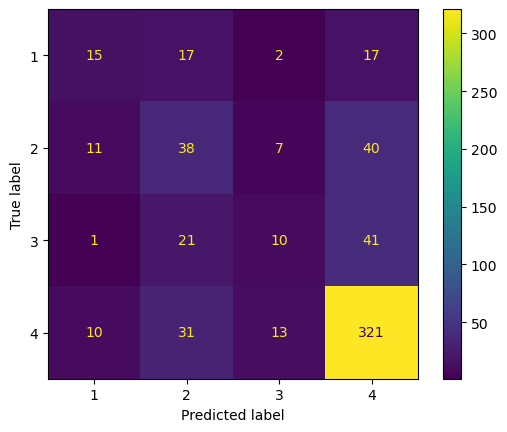

In [35]:
X_scaled = scaler.fit_transform(X)
nb = MultinomialNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred, y_true,  cm=True)

**Complement Naive Bayes + MinMaxScalar**

Accuracy: 0.61
F1 Score: 0.59
Recall: Label 1: 0.0 Label 2: 0.57 Label 3: 0.1 Label 4: 0.79


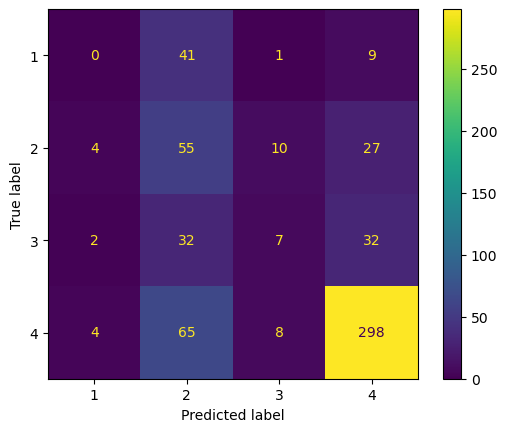

In [36]:
X_scaled = scaler.fit_transform(X)
nb = ComplementNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred, y_true, cm = True)

In general, the Naive Bayes Model performed with between 50% and 60% accuracy on training data across various iterations of the model.

Main Takeaways: 
* The model with the best accuracy was the **Bernoulli Naive Bayes with MinMaxScalar**. It had 65% accuracy, and even this model is one of the best performing, its accuracy is primarily due to the fact that it classfies 4, our over represented class, well. The recall values for this model are. Label 1: 0.29 Label 2: 0.4 Label 3: 0.14 Label 4: 0.86
* One of the biggest challenged we face in this project is figuring out how to handle the overrepresenation of group 4 in our data. Models that classfiy most data as 4 (the over represented class) may return higher accuracy but may be overall less useful. 
    * In general, models seemed to behave in 1 of 2 ways:
        1. Classifying most values as 4 (i.e. the *Bernoulli Naive Bayes with MinMaxScalar* above), or
        2. Split values between 2 and 4 (i.e. *Complement Naive Bayes + MinMaxScalar*)
    * **Complement Naive Bayes + MinMaxScalar**: This model has some of the highest accuracy of all the Naive Bayes Models (61%) and is also the best model classfiying 2: Recall: Label 1: 0.0 Label 2: 0.57 Label 3: 0.1 Label 4: 0.79
* Overall, MinMaxScalar seemed to be an important step to improve accuracy across the board.

For the KNN section, we attempted to build K Nearest Neighbors models with a variety of different inputs using SKlearn's KNN classifiers. We considered the following approach: using uniform or distance based weighting, changing the number of nearest features to select, regularizing the data, and considering a radius based as opposed to nearest neighbors based approach. In general, the results were disappointing, see below table for the full outcomes. I've reproduced the highest performing model below as an example of the model that performed best, however it is useful to note that its recall score shows that even this model is only really correctly classifying data in class 4.

Accuracy: 0.6
F1 Score: 0.53
Recall: Label 1: 0.04 Label 2: 0.1 Label 3: 0.1 Label 4: 0.9


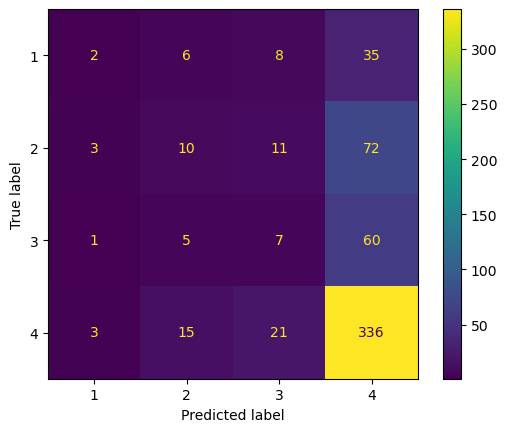

In [37]:
neigh = KNeighborsClassifier(n_neighbors=15, weights='distance')
neigh.fit(X,y)
pred = neigh.predict(X_valid)
evaluate_classification(pred,y_valid,cm=True)

\begin{array}{c|ccc}
\text{} & \text{accuracy} & \text{f1} & \text{recall [1,2,3,4]} \\
\hline
k\_15\_distance   &      0.60 &  0.53 &     [0.04, 0.1, 0.1, 0.9] \\
k\_20\_distance   &      0.61 &  0.53 &  [0.04, 0.09, 0.12, 0.91] \\
k\_3\_uniform     &      0.53 &  0.52 &  [0.22, 0.23, 0.07, 0.74] \\
k\_5\_uniform     &      0.55 &  0.52 &  [0.06, 0.19, 0.11, 0.79] \\
k\_10\_uniform    &      0.60 &  0.52 &  [0.02, 0.11, 0.04, 0.91] \\
k\_10\_distance   &      0.58 &  0.52 &   [0.04, 0.1, 0.12, 0.86] \\
k\_15\_uniform    &      0.62 &  0.52 &  [0.06, 0.07, 0.04, 0.94] \\
k\_20\_uniform    &      0.62 &  0.52 &  [0.02, 0.06, 0.04, 0.96] \\
k\_3\_distance    &      0.52 &  0.51 &  [0.08, 0.14, 0.18, 0.75] \\
k\_5\_distance    &      0.54 &  0.51 &  [0.06, 0.12, 0.14, 0.79] \\
re\_20\_distance  &      0.46 &  0.50 &  [0.29, 0.33, 0.34, 0.53] \\
rad\_3\_distance  &      0.63 &  0.49 &      [0.0, 0.0, 0.0, 1.0] \\
rad\_5\_distance  &      0.63 &  0.49 &     [0.0, 0.0, 0.0, 0.99] \\
re\_15\_distance  &      0.45 &  0.49 &  [0.31, 0.32, 0.32, 0.53] \\
rad\_3\_uniform   &      0.63 &  0.49 &      [0.0, 0.0, 0.0, 1.0] \\
re\_10\_distance  &      0.45 &  0.49 &  [0.37, 0.28, 0.33, 0.52] \\
re\_5\_distance   &      0.45 &  0.49 &   [0.24, 0.25, 0.3, 0.56] \\
rad\_20\_uniform  &      0.62 &  0.49 &    [0.0, 0.0, 0.01, 0.98] \\
rad\_20\_distance &      0.62 &  0.49 &    [0.0, 0.0, 0.01, 0.98] \\
rad\_5\_uniform   &      0.63 &  0.49 &     [0.0, 0.0, 0.0, 0.99] \\
re\_3\_distance   &      0.44 &  0.48 &  [0.24, 0.24, 0.27, 0.55] \\
rad\_10\_distance &      0.63 &  0.48 &     [0.0, 0.0, 0.0, 0.99] \\
rad\_15\_distance &      0.62 &  0.48 &     [0.0, 0.0, 0.0, 0.98] \\
rad\_15\_uniform  &      0.62 &  0.48 &     [0.0, 0.0, 0.0, 0.98] \\
rad\_10\_uniform  &      0.63 &  0.48 &     [0.0, 0.0, 0.0, 0.99] \\
re\_3\_uniform    &      0.43 &  0.47 &  [0.37, 0.32, 0.16, 0.51] \\
re\_5\_uniform    &      0.41 &  0.46 &  [0.35, 0.34, 0.25, 0.47] \\
re\_15\_uniform   &      0.40 &  0.45 &  [0.35, 0.34, 0.26, 0.45] \\
re\_20\_uniform   &      0.40 &  0.45 &  [0.39, 0.36, 0.27, 0.43] \\
re\_10\_uniform   &      0.39 &  0.44 &  [0.43, 0.31, 0.29, 0.42] \\
\end{array}

The KNN approach suffered from some issues we were not able to address, leading us to conclude this was not the right model. KNN uses all features by default, but our attempts at selecting only certain features was if anything less successful than using all features. Likewise, an attempt to break out 4 from the rest and then classify the rest between 1,2,3 did worse than a one stage classifier. Finally, when we tried to oversample our classes 1-3, the KNN model continued to predict only class 4. While we will continue to use some of these approaches to better classify our data, it is clear to us that KNN does not provide the best path forwards.

*Logistic Regression*\
The goal of logistic regression is to find the best parameters of a logistic function that minimizes the difference between the predicted probabilities and the actual outcomes. The logistic function uses the sigmoid function, which maps any real number into a range between 0 and 1, allowing us to interpret the output as a probability. The input features are weighted and combined linearly, and the resulting value is passed through the logistic function to produce a probability. We then use gradient descent to determine what the best classification is for these categories. Regularization helps to improve the generalization performance of the model by balancing the bias-variance trade-off and reducing overfitting.  By penalizing the weights of the input features, regularization encourages the model to focus on the most important features that are most relevant to the target variable. Overfitting occurs when a model learns to fit the training data too closely, including noise and irrelevant features, leading to poor generalization performance on new, unseen data. In this case we will try L2 regularization which adds a penalty term proportional to the square of the weights.

One drawback however, is that it assumes linear relationships which based on the diversity of our data, may not be true in this case. 

In [38]:
# Logistic Regression

ros = RandomOverSampler(random_state=0)
sm = SVMSMOTE(random_state=0)

#Train our data with two oversampling methods: SVM SMOTE and random sampling with replacement 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
train_df_resampled, train_y_resampled = ros.fit_resample(X_train, y_train)

sm = SVMSMOTE(random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

#Train our data with two oversampling methods: SVM SMOTE and random sampling with replacement 
print("With Smote- RFE")
#Recursive feature elimination
rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 6, step = 1)
rfe.fit(X_smote, y_smote)
y_pred = rfe.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("Features selected:With Smote- RFE")
print(X_train.iloc[:,[64,138,126,127,107,108,6]].columns)

print("With Random Selection- RFE")
#Recursive feature elimination
rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 6, step = 1)
rfe.fit(train_df_resampled, train_y_resampled)
y_pred = rfe.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)
print("Features selected:With Random Selection- RFE")
print(X_train.iloc[:,[36,37,42,45,107,108]].columns)


print("With Smote- Variance Threshold")
# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
a= X_smote.copy()
rev_x = sel.fit_transform(a)

reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)
y_pred = reg.predict(sel.transform(X_valid.copy()))
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("With Random Selection-Variance threshold")

# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
rev_x = sel.fit_transform(train_df_resampled.copy())
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, train_y_resampled)
a= X_valid.copy()
y_pred = reg.predict(sel.transform(a))
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

With Smote- RFE


While, if we reference the logistic regression function, without overweighting we only classify the majority class 4 (please see regression document). With overweighting and feature selection methods, we get our best predictors using regularized logistic regression in terms of classification accuracy and F1 score. But given the diversity of the results, it is clear feature selection as opposed to logistic regression usage is the most important part of this work. It is unclear if regularized logistic regression will be the best indicator going forward.

** Discussion **

** Next Steps **